# Sky Segmentation for Agricultural Images

Assumes:
- sky is always visible in the image,
- sky is always on the top half of the image,
- sky occupies no less than 85% of the image's width,
- sky never exceeds 50% of the image,
- sky has blue and white tint, or eventually pink, orange, violet and/or yellow.

In [68]:
from sky_segmentation import KMeansSky, IntensitySky
from matplotlib import cm
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os


In [69]:
# Definitions

TRD_PATH = '../resources/therosariodataset/sequence03_selected/'
TRD_FILES = [
    'left_1514557404.402000.png', 'left_1514557432.437000.png', 'left_1514557475.010000.png',
    'left_1514557504.408000.png', 'left_1514557528.874000.png', 'left_1514557564.762000.png',
    'left_1514557578.585000.png', 'left_1514557602.532000.png', 'left_1514557604.999000.png',
]

Z22_PATH = '../resources/zavalla2022/'
Z22_FILES = [
    'left0807.jpg', 'left1187.jpg', 'left1492.jpg',
    'left1550.jpg', 'left1750.jpg', 'left1876.jpg',
]

Z23_PATH = '../resources/zavalla2023/'
Z23_FILES = [
    'left0034.jpg', 'left0162.jpg', 'left0387.jpg',
    'left0707.jpg', 'left0810.jpg',
]

SAVE_IMAGES = False
SAVE_PATH = '../resources/results/'
if SAVE_IMAGES:
    os.makedirs(SAVE_PATH, exist_ok=True)
SAVE_INDEX = 0

In [70]:
# Read images
def read_images(path, imlist):
    images = []
    for imname in imlist:
        img = cv2.imread(path+imname)
        images.append(img)
    return images

# Make a gridplot of the images
def plot_images_grid(imlist, step=3, cvtcolor=False):
    global SAVE_INDEX
    if SAVE_IMAGES:
        for i,img in enumerate(imlist):
            impath = SAVE_PATH + f'seg{SAVE_INDEX}_{i}.png'
            cv2.imwrite(impath, img)
        SAVE_INDEX += 1
    rows = -(len(imlist) // -step)  # ceiling = upside-down floor
    fig, axs = plt.subplots(rows, step)
    for i,img in enumerate(imlist):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if cvtcolor else img
        axs[i//step, i%step].imshow(img)
        axs[i//step, i%step].axis('off')
    return fig, axs

# Overlay a cluster/mask with the original image
def overlay_segmentation(
        original_image, segmented_image, alpha=0.25, colormap='tab20'):
    unique_clusters = np.unique(segmented_image)
    num_clusters = len(unique_clusters)

    # Map each cluster to a color from the specified colormap
    cmap = cm.get_cmap(colormap, num_clusters)
    color_map = (
            cmap(np.linspace(0, 1, num_clusters))[:, :3] * 255
        ).astype(np.uint8)

    # Create a color mask based on the segmented image
    color_mask = np.zeros_like(original_image, dtype=np.uint8)
    for idx, cluster in enumerate(unique_clusters):
        color_mask[segmented_image == cluster] = color_map[idx]

    # Blend the color mask with the original image
    overlay_image = cv2.addWeighted(
        original_image, 1 - alpha, color_mask, alpha, 0)
    
    cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
    return overlay_image


def plot_sky_earth_separation(image, mask):
    """
    Plots the separation between sky and earth by overlaying contours on the original image.

    Parameters:
        image: The original image as a NumPy array (H x W x 3).
        mask: A boolean mask where True represents sky and False represents earth (H x W).
    """
    # Convert the boolean mask to uint8 (0 and 255) for contour detection
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Find contours on the binary mask
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Copy the original image to draw contours on
    image_with_contours = image.copy()

    # Draw contours on the image in red
    cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 3)  # Red color, 2px thickness

    return image_with_contours


def plot_segmentation_image(label_image):
    """
    Plots a segmentation image where each pixel contains a label number.

    Parameters:
        label_image: 2D numpy array, each pixel is an integer label (e.g., 0, 1, 2, ... N).
    """
    # Get unique labels in the image
    unique_labels = np.unique(label_image)
    
    # Define a colormap with one unique color per label
    colormap = plt.get_cmap("tab20c", len(unique_labels))
    
    # Normalize labels for colormap (map labels to range 0 to 1)
    norm = mcolors.Normalize(vmin=unique_labels.min(), vmax=unique_labels.max())
    
    # Apply colormap to label image
    colored_image = colormap(norm(label_image))

    return colored_image  # FIXME: multiply by 255 when saving


## Original Images

/tmp/ipykernel_25897/3383977010.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/3383977010.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/3383977010.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


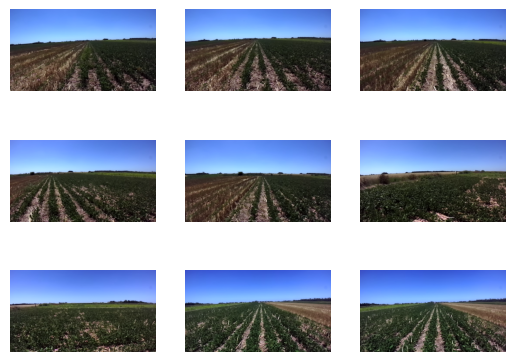

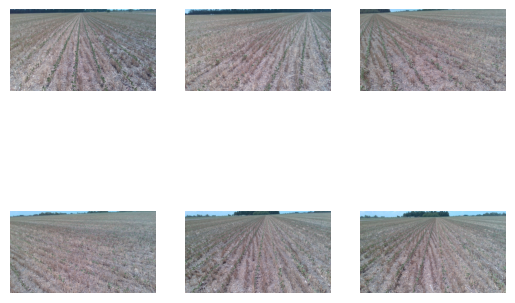

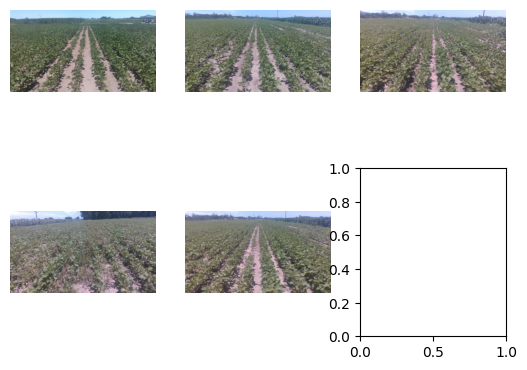

In [71]:
# The Rosario Dataset
trd_images = read_images(TRD_PATH, TRD_FILES)
fig, axs = plot_images_grid(trd_images, cvtcolor=True)
fig.show()

# Zavalla 2022
z22_images = read_images(Z22_PATH, Z22_FILES)
fig, axs = plot_images_grid(z22_images, cvtcolor=True)
fig.show()

# Zavalla 2023
z23_images = read_images(Z23_PATH, Z23_FILES)
fig, axs = plot_images_grid(z23_images, cvtcolor=True)
fig.show()

## Segmented Images

### Intensity

/tmp/ipykernel_25897/1516606254.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/1516606254.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig

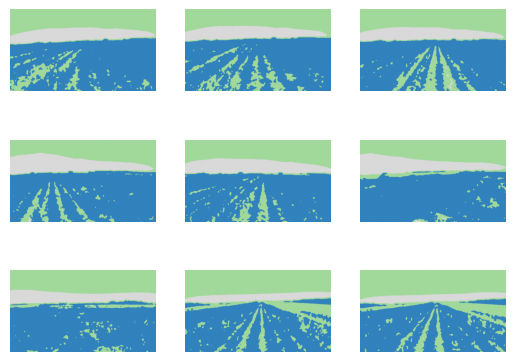

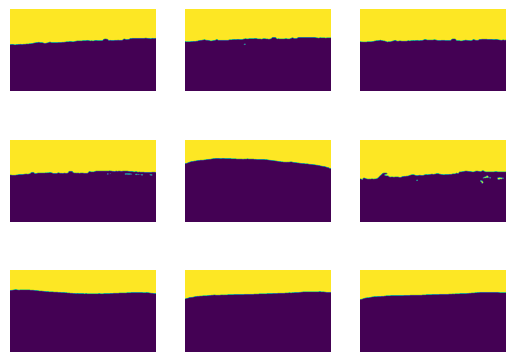

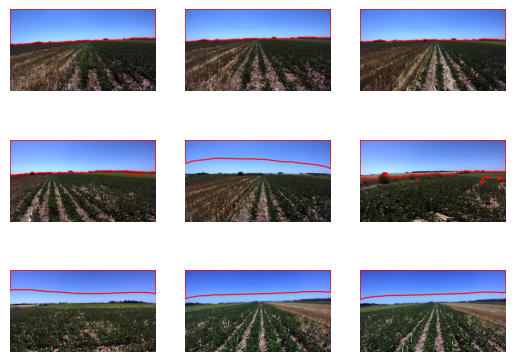

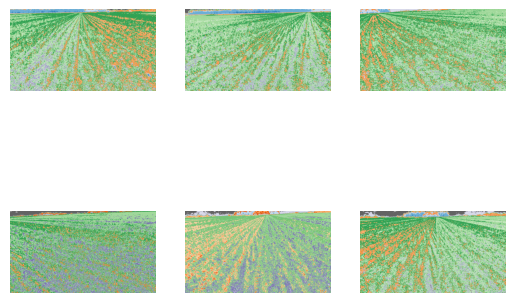

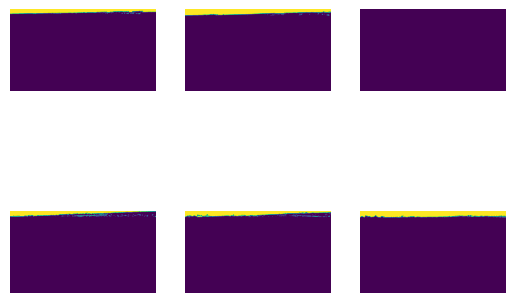

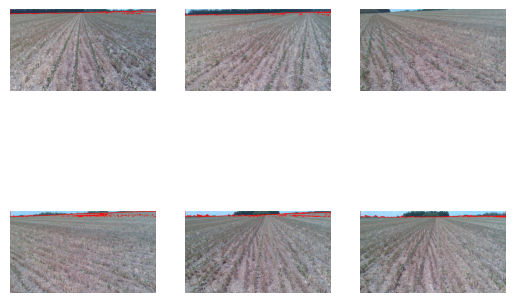

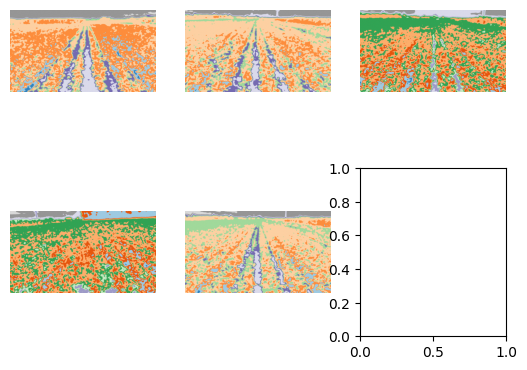

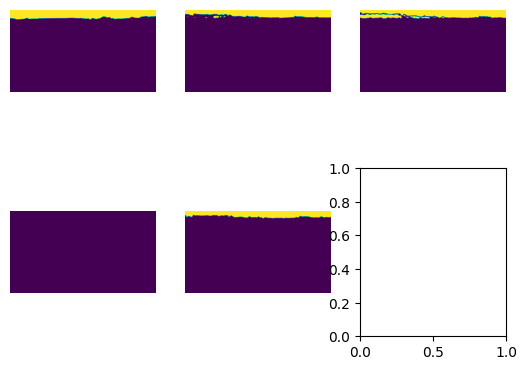

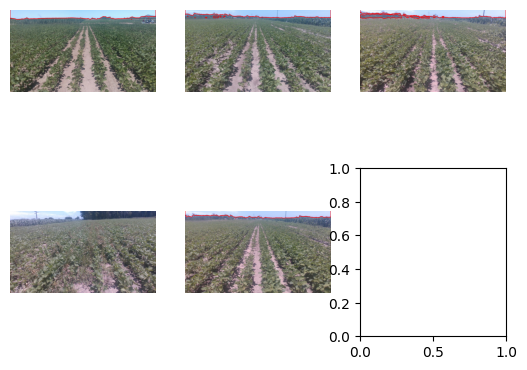

In [72]:
## Intensity Segmentation

# The Rosario Dataset
trd_intensity_args = {
    'ksize': (15,15),
    'sigmaX': 0,
    'k': 3
}
trd_intensity = []
trd_clustering = []
trd_overlay = []
for img in trd_images:
    i_clus, i_img = IntensitySky(img, **trd_intensity_args)
    trd_intensity.append((i_img * 255).astype(np.uint8))
    trd_clustering.append(plot_segmentation_image(i_clus))
    trd_overlay.append(plot_sky_earth_separation(img, i_img))

fig, axs = plot_images_grid(trd_clustering)
fig.show()
fig, axs = plot_images_grid(trd_intensity)
fig.show()
fig, axs = plot_images_grid(trd_overlay, cvtcolor=True)
fig.show()

# Zavalla 2022
z22_intensity_args = {
    'ksize': (5,5),
    'sigmaX': 0,
    'k': 15
}
z22_intensity = []
z22_clustering = []
z22_overlay = []
for img in z22_images:
    i_clus, i_img = IntensitySky(img, **z22_intensity_args)
    z22_intensity.append((i_img * 255).astype(np.uint8))
    z22_clustering.append(plot_segmentation_image(i_clus))
    z22_overlay.append(plot_sky_earth_separation(img, i_img))
fig, axs = plot_images_grid(z22_clustering)
fig.show()
fig, axs = plot_images_grid(z22_intensity)
fig.show()
fig, axs = plot_images_grid(z22_overlay, cvtcolor=True)
fig.show()

# Zavalla 2023
z23_intensity_args = {
    'ksize': (25,25),
    'sigmaX': 0,
    'k': 10
}
z23_intensity = []
z23_clustering = []
z23_overlay = []
for img in z23_images:
    i_clus, i_img = IntensitySky(img, **z23_intensity_args)
    z23_intensity.append((i_img * 255).astype(np.uint8))
    z23_clustering.append(plot_segmentation_image(i_clus))
    z23_overlay.append(plot_sky_earth_separation(img, i_img))
fig, axs = plot_images_grid(z23_clustering)
fig.show()
fig, axs = plot_images_grid(z23_intensity)
fig.show()
fig, axs = plot_images_grid(z23_overlay, cvtcolor=True)
fig.show()

### K-Means

/tmp/ipykernel_25897/4263114796.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25897/4263114796.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig

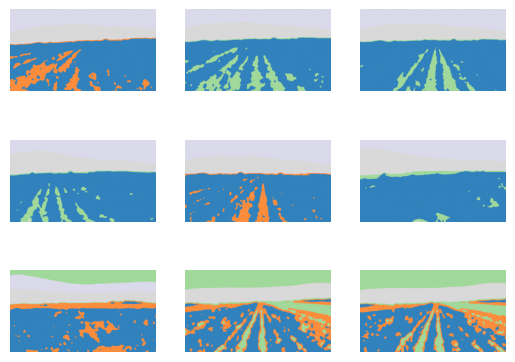

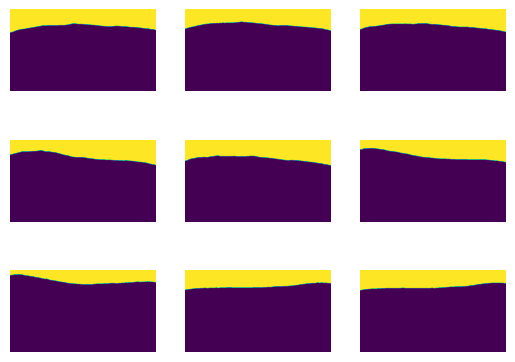

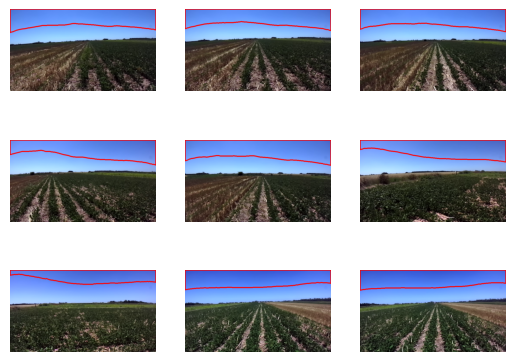

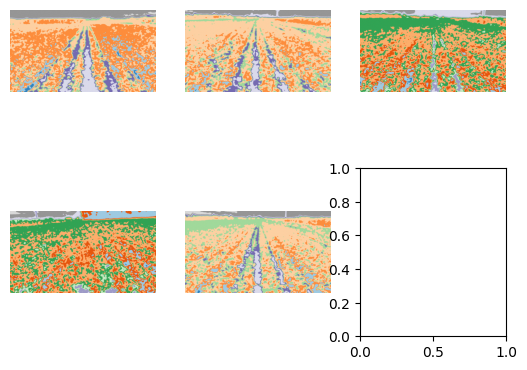

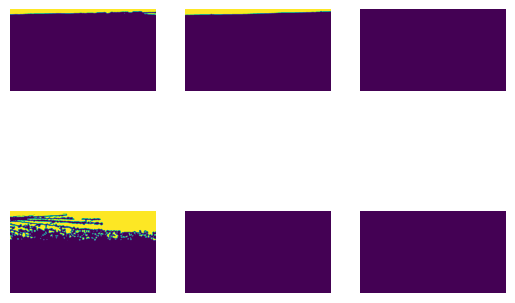

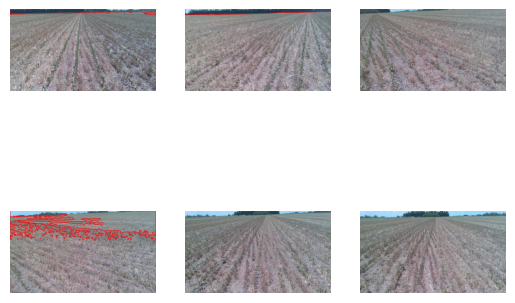

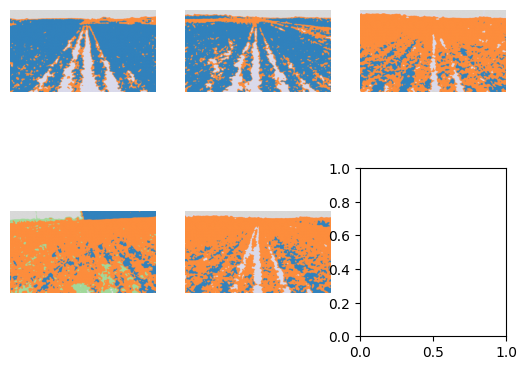

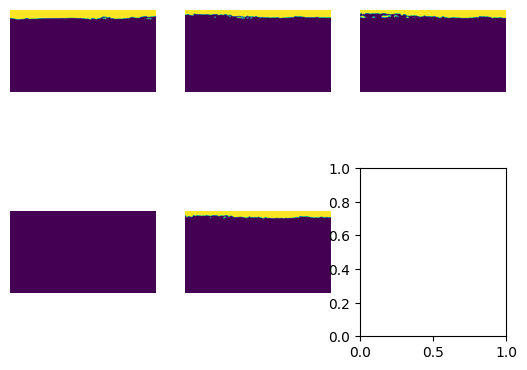

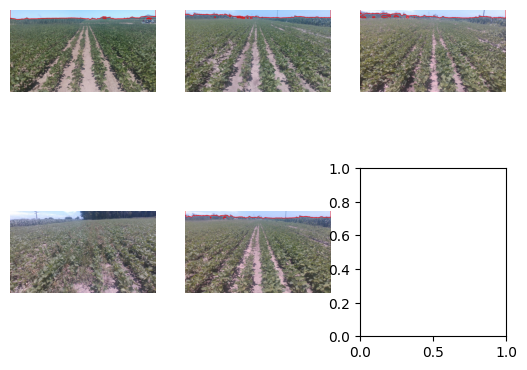

In [73]:
## K-Means Segmentation

# The Rosario Dataset
trd_kmeans_args = {
    'ksize': (25,25),
    'sigmaX': 0,
    'k': 3
}
trd_kmeans = []
trd_clustering = []
trd_overlay = []
for img in trd_images:
    i_clus, i_img = KMeansSky(img)
    trd_kmeans.append((i_img * 255).astype(np.uint8))
    trd_clustering.append(plot_segmentation_image(i_clus))
    trd_overlay.append(plot_sky_earth_separation(img, i_img))
fig, axs = plot_images_grid(trd_clustering)
fig.show()
fig, axs = plot_images_grid(trd_kmeans)
fig.show()
fig, axs = plot_images_grid(trd_overlay, cvtcolor=True)
fig.show()


# Zavalla 2022
z22_kmeans_args = {
    'ksize': (5,5),
    'sigmaX': 0,
    'k': 15
}
z22_kmeans = []
z22_clustering = []
z22_overlay = []
for img in z22_images:
    i_clus, i_img = KMeansSky(img)
    z22_kmeans.append((i_img * 255).astype(np.uint8))
    z22_clustering.append(plot_segmentation_image(i_clus))
    z22_overlay.append(plot_sky_earth_separation(img, i_img))
fig, axs = plot_images_grid(z23_clustering)
fig.show()
fig, axs = plot_images_grid(z22_kmeans)
fig.show()
fig, axs = plot_images_grid(z22_overlay, cvtcolor=True)
fig.show()


# Zavalla 2023
z23_kmeans_args = {
    'ksize': (25,25),
    'sigmaX': 0,
    'k': 5
}
z23_kmeans = []
z23_clustering = []
z23_overlay = []
for img in z23_images:
    i_clus, i_img = KMeansSky(img)
    z23_kmeans.append((i_img * 255).astype(np.uint8))
    z23_clustering.append(plot_segmentation_image(i_clus))
    z23_overlay.append(plot_sky_earth_separation(img, i_img))
fig, axs = plot_images_grid(z23_clustering)
fig.show()
fig, axs = plot_images_grid(z23_kmeans)
fig.show()
fig, axs = plot_images_grid(z23_overlay, cvtcolor=True)
fig.show()
